# Candlestick patterns for one stock

## Load libraries
At first, we will load up some dependencies that we will make use of later on. We follow the convention of naming them a standard alias for easier handling.

In [1]:
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import talib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from IPython.display import Image
import inspect
from pathlib import Path

from BSquant import load_data
from BSquant import process_data
from BSquant import cs_pattern_recognition
from BSquant import cs_performance
from BSquant import plot_cs_performance
from BSquant import compute_trading_strategy_performance

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

# What is a candle stick and what are candlestick patterns?
This section aims at briefly describing what candlesticks are, so we bring everyone up to speed regarding this graphical representation of price data. 

## Anatomy of a candlestick (aka Japanese candlesticks)

A candlestick summarizes the four key price levels of a security within a specific time interval, such as 1 minute, 1 hour, or more commonly, 1 day. Candlesticks can also represent price data over various different intervals, such as 5 minutes, 4 hours, or any other specified duration.

These price levels include the opening price, highest price, lowest price, and closing price within the specific time interval. Candlesticks are typically colored green when the `close price > open price`, indicating a price increase during the interval, which defines a `bullish candle`. Conversely, they are colored red when the `close price < open price`, indicating a price decrease, which defines a `bearish candle`. The area between the opening and closing prices is known as the body of the candlestick.

A candlestick can also feature wicks above and below the body, known as the `upper wick` and `lower wick`, respectively. The lower wick of a bullish candle represents the distance between the lowest price and the opening price. In case of a bearish candle, it is the distance between the lowest price and the closing price. Conversely, the upper wick of a bullish candle illustrates the range from the closing price to the highest price, or, or a bearish candle, the distance from the opening price to the highest price.

Price summaries that adhere to the described structure are known as `Japanese candlesticks`. This naming traces back to their origins in Japan, where they were first developed. In contrast, practitioners in Europe and the United States commonly use a concept known as a price bar. Unlike candlesticks, price bars do not visually differentiate the market's mood (i.e., bullish or bearish) through a colored body. Instead, they indicate the opening and closing prices with markers positioned to the left and right, respectively. This makes price bars less graphically intuitive for interpreting market movements.

The image below illustrates the concepts explained.

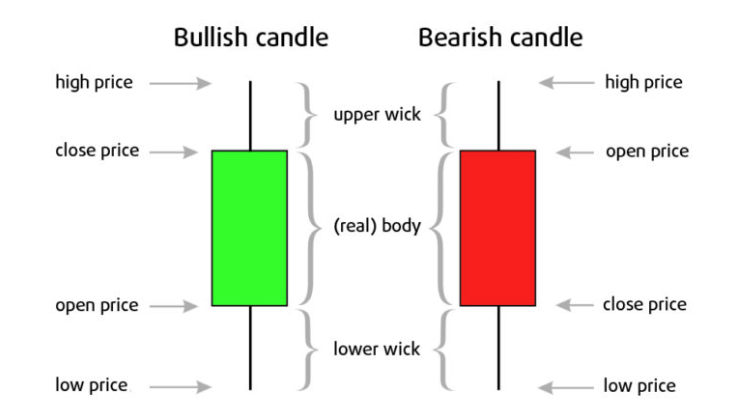

In [2]:
Image(filename="./../figures/candlestick_anatomy.png")

[Source: https://tradingcryptocourse.com/free/technical-analysis-candlesticks/]

## Candlestick patterns

Two or more candlesticks may form what is known as a candlestick pattern. The question arises: Why are these patterns significant? According to the efficient market hypothesis, they should not be. This theory suggests that all information affecting the price of an equity in a frictionless market is already accounted for in the price, based on the consensus between buyers and sellers at any moment the market is open. Crucially, this would mean prices follow a `Markov Process`, with the best predictor for the price at `t+1` being the price at `t`. Candlestick analysis, however, challenges this notion. It posits that certain patterns can predict price movements in the subsequent time interval, indicating that prices may not solely rely on the most recent information, but that, in fact, history repeats it self following specific patterns. 

This project does not seek to challenge the efficient market hypothesis directly. Rather, our aim is to analyze a substantial volume of financial data from liquid stocks within the `S&P 500`, sourced from a reliable provider, to determine if there is statistical evidence supporting the hypothesis of those following candle stick analysis. Our null hypothesis posits that the likelihood of a positive intraday return at `t+1` is equal to the likelihood of a negative intraday return at `t+1`, both set at 50%, or expressed formulaically as:

$$
P(\text{positive intraday return})_{t+1} = P(\text{negative intraday return})_{t+1} = 0.5
$$

Let us now examine some "special" candlesticks and patterns, as illustrated in the image below. "Special" candlesticks, such as the `Hammer` and the `Black Marubozu`, can independently signal potential future price movements without forming patterns with other candlesticks. Take the `Black Marubozu` as an example. This candlestick indicates a trading period dominated by declining prices. While we do not have tick-by-tick price details, which might have indeed shown temporary periods of rising prices, the `Black Marubozu` reveals that the period opened at its highest price (`open price = high price`) and closed at its lowest (`close price = low price`). This scenario spells trouble for traders in long positions but is ideal for those holding short positions. The presence of a `Black Marubozu` suggests an expectation for prices to continue falling in the subsequent period.

Examining the `Black Morning Star`, we observe it consists of three candles. The pattern begins with two bearish candles, indicating a price decline over these periods. Notably, the second candle opens just below the close of the first, creating what is known as a `body gap`. This detail underscores the momentum of the downward trend, more so than if the second candle's opening were within the body of the first. Despite a slight recovery marking the day's high, the price falls again, closing slightly higher than its low. Up to this point, the narrative has been decidedly bearish. However, the third period brings a turn of events. It opens above the previous candle's opening price, signaling a potential shift. The third time interval is marked by predominately rising prices, closing significantly above its opening price, and crucially, higher than the opening price of day one. This formation, known as a `Black Morning Star`, is interpreted by candlestick analysts as signaling the end of a downtrend and suggesting a potential rise in prices in the following period. Whether this holds true will be statisticdally evaluated in this project.

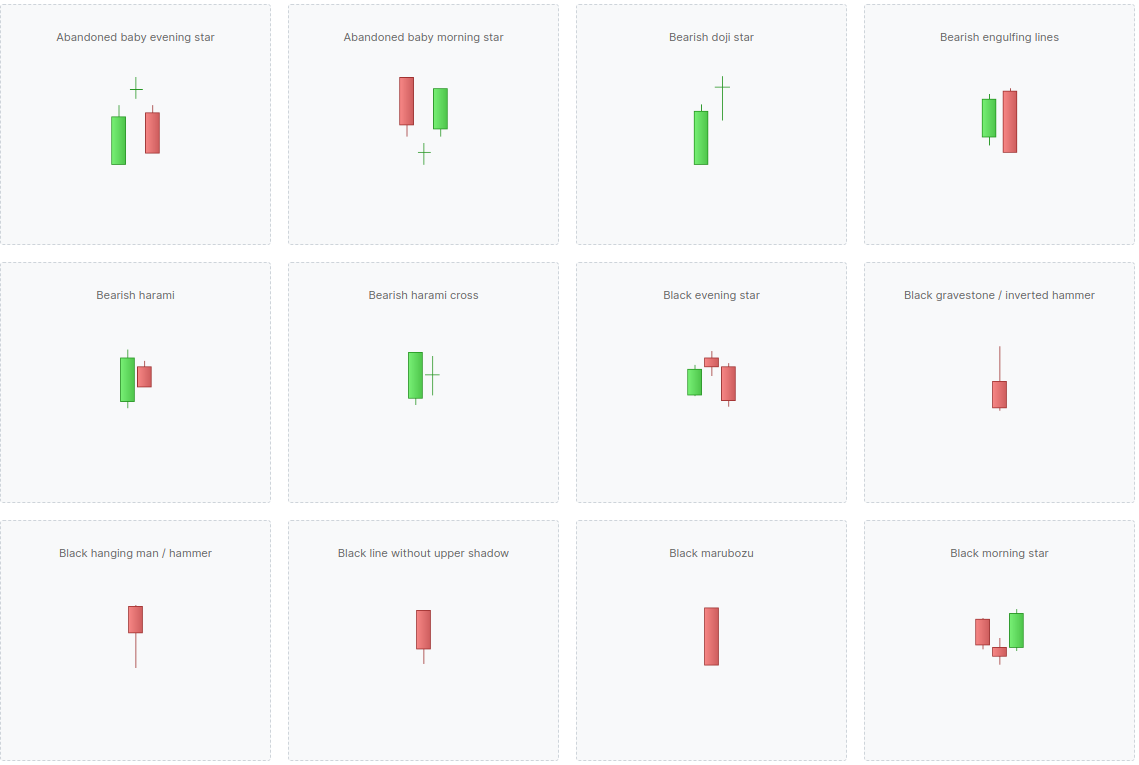

In [3]:
Image(filename="./../figures/cs_patterns.png")

[Source: https://www.prorealtime.com/en/help-manual/candlesticks-patterns]

Let us now load in data for a single stock and run through a complete analysis before we embark on analysing the whole S&P 500 universe. The remainder of this notebook is aimed at introducing you to how we can translate our ideas to code making use of a computer to analyse a vasta amount of data that would be infeasible cumbersome to do by hand, or even in a spreadsheet. We will make use of CRSP data that we downloaded for the  S&P 500 via WRDS (see detailed instruction in the first notebook). 

# Loading and pre-processing the data

We can now proceed loading and analysing data. We limit ourselves to a one stock case in this notebook to demonstrate the concepts and progress towardes the whole investment universe in the next one. Given the structure of the project, you need to pass the filename of the data that you previously downloaded from `WRDS`. In our case that filename is `SP500_daily_data_1980_to_2023.csv.gz`. I set up some helper functons that assist you doing this. The relevant functions can be imported like so:

     from BSquant import load_data
     from BSquant import process_data
 
In software engineering there is the principle of `high cohesion` within functions, to enhancee code maintainability. High cohesion means each function is dedicated to a single task, thereby reducing dependencies among different parts of the code. For example, in our case, `load_data` is solely focused on loading data, and `process_data` is specifically designed for preprocessing steps. This separation of concerns not only clarifies the code's structure but also simplifies future modifications and debugging.

Furthermore, it is crucial to document each function clearly. A well-crafted docstring should accompany every function, explaining its purpose, parameters, and return values. This practice not only aids your understanding but also assists your fellow researchers in grasping the functionality and intent of the code.
 
You can display a function's docstring by using the `help(`) function and passing the function's name as an argument. Alternatively, to view a function's definition, you can utilize the `inspect` module. Let us explore each method to ensure you can effectively apply them in the future.

In [4]:
help(load_data)  # displays the doc string of a function

Help on function load_data in module BSquant:

load_data(file_path: pathlib.Path, compression: Optional[str] = 'gzip', ticker: Optional[str] = None, selected_start_date: Optional[pandas._libs.tslibs.timestamps.Timestamp] = None, selected_end_date: Optional[pandas._libs.tslibs.timestamps.Timestamp] = None) -> pandas.core.frame.DataFrame
    Loads data from a compressed CSV file, filters it based on optional criteria,
    and returns a cleaned pandas DataFrame.
    
    The function reads a CSV file, optionally compressed, renames columns for consistency,
    filters the data by a specified ticker and date range, and returns the processed DataFrame.
    
    Args:
        file_path (Path): Path to the compressed CSV file.
        compression (Optional[str], optional): Compression type of the CSV file. Defaults to 'gzip'.
        ticker (Optional[str], optional): Specific ticker to filter on. If None, no ticker filtering is applied.
        selected_start_date (Optional[pd.Timestamp], opt

In [ ]:
print(
    inspect.getsource(load_data)
)  # displays the source code of a class/function. Assumes `load_data` is already defined or imported

Note: An interactive alternative to statically printing the source code in Jupyter, is to invoke the function name followed by two question marks in a code cell.

In [6]:
load_data??

You see, `load_data` demands the path to the location where the data is stored. Optionally, you can input the compression mechanim of the file, pass a ticker, as well as define a start and and end date, if you wish to restrict the analysis to a particular stock within a specific time frame. In the present case, we want to obtain data for `Microsoft` only. Its ticker is `MSFT`.

Looking at the function definition, you see we rename the column names. Strictly speaking this is not a necessity, however, a column called `date` is probably more intuitive to understand than `DlyCalDt`. Also, by convention, column names are usually considered to be named in lower-case letters. You then see that we choose the columns we wish to import. An important step is to convert the dates to a proper datetime format. This is a crucial step as without a conversion, they would be considered strings and as such lose important properties for example, setting them as an index, or filtering between two dates. For clarity, we pass the formate in which CRPS dates are stored. In out case the CRSP format for dates in daily freqeuncy is `format="%Y-%m-%d`. For an exhaustive overview on that abbreviations are available, please consult :
https://docs.python.org/3/library/datetime.html

We then carry out the optional filtering steps by ticker and timeinterval, and return the data frame. 

Let us now define the path, as well as passing the necessary input parameters to `load_data` in the cells below to see the function being applied in practice.

In [7]:
# define the filename of the stock market data (dependent on how you named the file on your system).
# set up the path to the data (independently on your system thanks to the pathlib library).
data_filename = "SP500_daily_data_1980_to_2023.csv.gz"

notebooks_dir = Path("./../notebooks")
data_file_path = notebooks_dir.parent / "data" / data_filename
print(data_file_path)

../data/SP500_daily_data_1980_to_2023.csv.gz


In [8]:
df = load_data(
    file_path=data_file_path,
    compression="gzip",
    ticker="MSFT",
    selected_start_date=pd.Timestamp(1992, 1, 1),
    selected_end_date=pd.Timestamp(2022, 12, 31),
)

The function `process_data` (displayed in the next cell) is tasked with processing data retrieved by `load_data`, with one of its key operations being the removal of rows containing `NaN` values. This method is notably aggressive and results in the loss of approximately 20% of the data across the entire dataset. To potentially reduce this loss, there are a few considerations:

- Data provider inquiry: Inquiring with the data provider about the missing data may provide clues into the nature of these gaps. In scenarios like exchange outages or other reasons for missing records, accurately reconstructing the exact historical data is highly unlikely, if not impossible.

- Data interpolation: Another strategy is to interpolate missing values. However, this comes with caveats. Any form of interpolation, will alter the final analysis outcomes. The difficulties of error propagation through interpolated data is considerable, making it a difficult process to assess how these changes impact overall results.

Also, in `process_data`, we employ `method chaining` with `Pandas`, which offers several advantages for managing and transforming dataframes. Method chaining allows for operations to be applied sequentially without modifying the original dataset, preserving the raw data unless explicitly overwritten. This approach is made possible by passing the dataframe from one operation to the next, with each method call returning a new dataframe upon which subsequent operations can act. One of the benefits of method chaining is enhanced readability and maintainability of the code. It presents the data processing workflow in a clear, step-by-step manner, making it easier to understand and modify the processing sequence at later stages.
It is important to note that method chaining relies on each operation returning a modified copy of the dataframe. Therefore, operations that return `None` disrupt the chain, leading to undesired behavior. 

We proceed to calculate `intraday returns` as well as their sign. An intraday return is defined as follows:

$$
intraday\_return_t = \frac{close_t - open_t}{open_t} = \frac{close_t}{open_t} - 1
$$

It is important to note that intraday returns are defined differently from `daily returns`. While intraday returns are calculated by comparing the closing and opening prices within the same trading day, daily returns typically consider only the closing prices across consecutive days:

$$
daily\_return_t = \frac{close_t - close_{t-1}}{close_{t-1}} = \frac{close_t}{close_{t-1}} - 1
$$

The `shift` operator is utilised to align intraday returns at times 
$t$ and $t+1$. This alignment allows us to transparently evaluate the accuracy of predictions made by our candlestick patterns against the actual intraday returns observed in the market on the following day. By examining whether the signed returns at $t+1$ conform to the predictions, we can assess the effectiveness of our model.

Please note that the DataFrame retains certain information which, while not immediately necessary for this project, is beneficial for future analyses. This includes the precise numeric values of intraday returns, the volume of stocks traded, and the price volume for the day. Such details are important for conducting regression-type econometric studies on return series and for calculating the `Volume Weighted Average Price (VWAP)`. VWAP, defined as the scalar product of transactional price and stock volume divided by the L-2 norm of the volume vector. It is widely used to assess the performance of execution algorithms and proprietary trading strategies, making it an important metric for future investigations.

Additionally, although the computation of log-returns based on daily closing prices is currently commented out, it has been preserved to facilitate a direct comparison with intraday returns in potential future studies.

Let us now display the source code as make the function act on the loaded data. 

In [9]:
print(inspect.getsource(process_data))  # displays the source code of `process_data`

def process_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the given DataFrame by cleaning data, calculating intraday returns,
    and preparing for subsequent analysis.

    This function performs several steps:
    - Drops any rows with missing values.
    - Converts the volume column to integers.
    - Calculates the intraday return as (close - open) / open.
    - Determines the sign of the intraday return (positive, negative, or zero) as an integer.
    - Shifts the intraday returns and their signs to prepare for next-day return analysis.

    Parameters:
        df (pd.DataFrame): The DataFrame to process. Expects columns 'vol', 'open',
                           and 'close' to be present.

    Returns:
        pd.DataFrame: A DataFrame with the original data plus additional columns for
                      'intraday_return', 'sign_intraday_return', 'next_intraday_return',
                      and 'sign_next_day_return'. Rows with missing values after processing
 

In [10]:
df = process_data(df)  # let us now obtain the processed data
df.head(5)

ticker       date     prc      vol   close    low   high  open    price_vol  \
0   MSFT 1992-06-15  75.750  1707931  75.750  75.00  78.00  75.0  129375773.3   
1   MSFT 1992-06-16  72.750  1800280  72.750  72.50  76.50  75.5  130970370.0   
2   MSFT 1992-06-17  72.375  2196679  72.375  71.50  73.25  72.5  158984642.6   
3   MSFT 1992-06-18  72.250  1706769  72.250  71.00  74.75  73.0  123314060.3   
4   MSFT 1992-06-19  73.500  1350828  73.500  72.75  74.25  73.5   99285858.0   

   intraday_return  sign_intraday_return  next_intraday_return  \
0         0.010000                     1             -0.036424   
1        -0.036424                    -1             -0.001724   
2        -0.001724                    -1             -0.010274   
3        -0.010274                    -1              0.000000   
4         0.000000                     0              0.013652   

   sign_next_day_return  
0                    -1  
1                    -1  
2                    -1  
3                     0  
4                     1

# Displaying price data in candlestick form

In this section, we explore how to plot candlestick charts in Python. While plotting data for extensive analysis is cumbersome (imagine plotting several years of data for 500 stocks), we will primarily rely on computation to assess the effectiveness of candlestick patterns. Nonetheless, for a small subset of data and for illustrative purposes, visualizing candlestick charts remains a worthwhile exercise.

We will examine two methods: 

    1) An efficient (yet less aesthetic) method using an `np.array` and `matplotlib`.
    2) A more aesthetic (but less efficient) method using a `pd.DataFrame` and `plotly`.
    
    
## Efficient (and less aestetic) method using an `np.array` and `matplotlib`

The function `ohlc_plot_candles` is a modification from https://github.com/sofienkaabar/mastering-financial-pattern-recognition/blob/main/Master_Function_MFPR.py and utilizes only OHLC (Open, High, Low, Close) data. This data is selected from our processed DataFrame, and a lookback period is specified. As discussed in the section "Anatomy of a Candlestick (aka Japanese Candlesticks)," we denote bullish days in green and bearish days in red, with upper and lower wicks marked in black.

In [11]:
def ohlc_plot_candles_mpl(data: np.array, window: int) -> plt.Figure:
    """
    Plotting OHLC data using an np.array (modified after https://github.com/sofienkaabar/mastering-financial-pattern-recognition/blob/main/Master_Function_MFPR.py)
    """
    plt.figure(figsize=(10, 10))
    sample = data[-window:,]

    for i in range(len(sample)):
        plt.vlines(
            x=i, ymin=sample[i, 2], ymax=sample[i, 1], color="black", linewidth=1
        )
        if sample[i, 3] > sample[i, 0]:
            plt.vlines(
                x=i, ymin=sample[i, 0], ymax=sample[i, 3], color="green", linewidth=1
            )
        if sample[i, 3] < sample[i, 0]:
            plt.vlines(
                x=i, ymin=sample[i, 3], ymax=sample[i, 0], color="red", linewidth=1
            )
        if sample[i, 3] == sample[i, 0]:
            plt.vlines(
                x=i,
                ymin=sample[i, 3],
                ymax=sample[i, 0] + 0.00005,
                color="black",
                linewidth=1.00,
            )
    plt.title("Price of seleced asset diplayed as candlestick chart")
    plt.xlabel("data points [daily frequency]")
    plt.ylabel("price [currency the stock is priced in]")
    plt.grid()

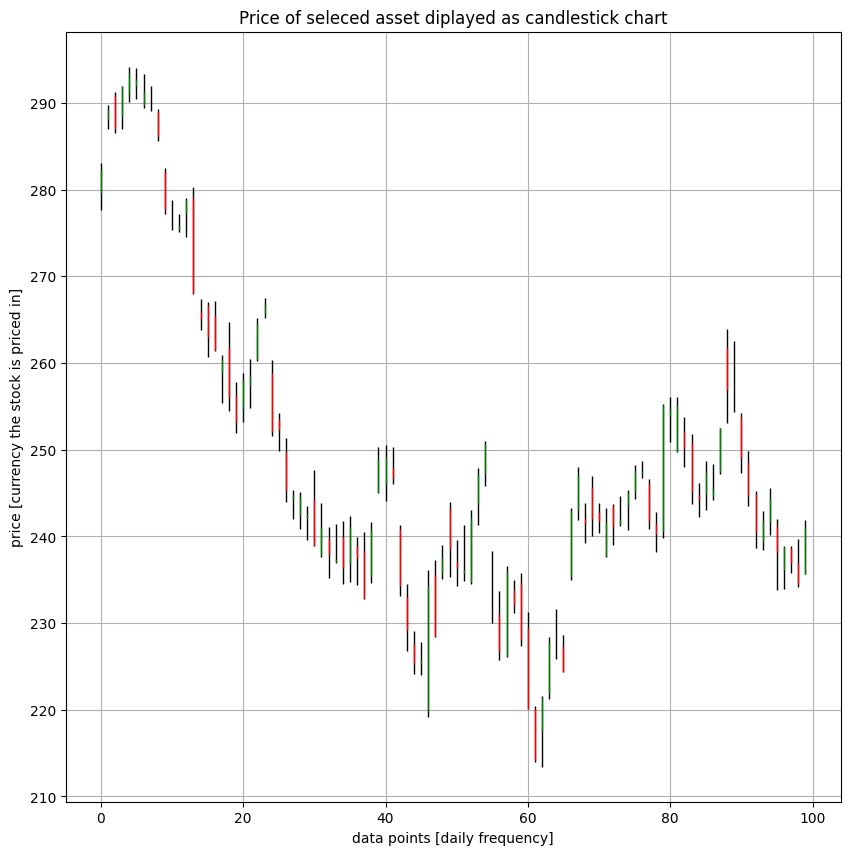

In [12]:
ohlc_plot_candles_mpl(data=df[["open", "high", "low", "close"]].values, window=100)

## More aestetic (but less efficient) method using a `pd.DataFrame` and `plotly`

The second method employs `plotly`, a library renowned for producing publication-ready, interactive plots that are especially useful within a `Jupyter notebook` environment. While `plotly` is more complex and less memory-efficient than `matplotlib`, it excels in creating visually appealing charts suitable for a limited dataset. The general recommendation is to prototype with `matplotlib` due to its simplicity and efficiency, and then switch to `plotly` for presenting final results.

To utilize this method, we supply the OHLC data in a `DataFrame`, with an additional requirement for the `date` column. This inclusion is crucial for accurately formatting the date on the x-axis. Furthermore, it necessitates setting the `DataFrame's` index to the date column, which should contain datetime objects. Additionally, for improved visibility, we constrain the `DataFrame` to display only the most recent 100 days of data.

In [13]:
def ohlc_plot_candles_plotly(df: pd.DataFrame) -> go.Figure:
    fig = go.Figure(
        data=[
            go.Candlestick(
                x=df.index,
                open=df["open"],
                high=df["high"],
                low=df["low"],
                close=df["close"],
            )
        ]
    )

    fig.update_layout(
        font={"size": 18},
        legend={
            "yanchor": "top",
            "y": 0.99,
            "xanchor": "right",
            "x": 0.99,
            "font": {"size": 20},
        },
        title="Price of seleced asset diplayed as candlestick chart",
        xaxis_title="date [daily frequency]",
        yaxis_title="price [currency the stock is priced in]",
        autosize=False,
        width=800,
        height=800,
    )

    fig.show()

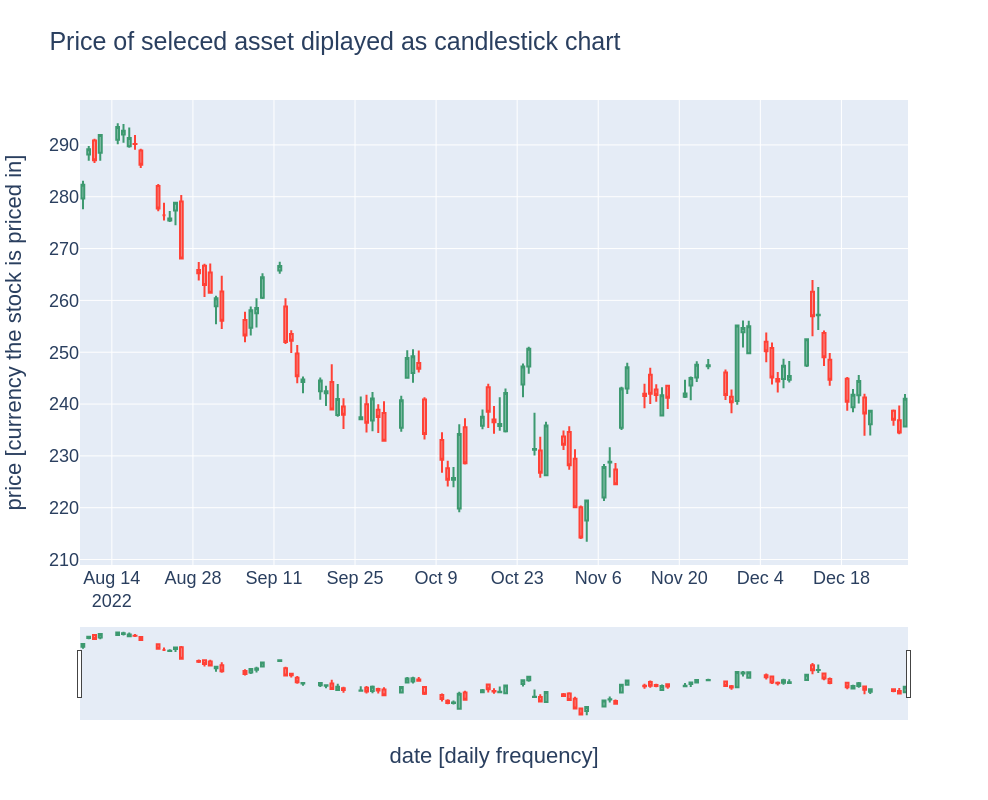

In [14]:
ohlc_plot_candles_plotly(
    df=df[["date", "open", "high", "low", "close"]].set_index("date")[-100:]
)

# What candlestick patterns are available?

Having understood the visual aspects of candlestick patterns, our next step is to identify these patterns within financial data. Fortunately, we have access to `talib`, a pattern recognition library written in `C++`. Its efficiency not only provides convenience but also spares us the considerable effort of manually coding these patterns, a task that could easily constitute a Bachelor's or even Master's thesis.

`talib` is proficient in detecting candlestick patterns, indicating not only their occurrence but also classifying them as bearish or bullish. The library is capable of recognizing 63 distinct candlestick patterns. For example, the first five patterns include `2 Crows`, `3 Black Crows`, `3 Inside`, `3 Line Strike`, and `3 Outside`. While the names of these patterns are a topic on their own for enthusiasts, our focus is on the signals they provide and whether the subsequent intraday returns align with their predictions.

The function `cs_pattern_recognition` living within `BSquant.py` is instrumental in performing candlestick pattern recognition, utilizing our previously processed data as its input. This function generates a multi-index DataFrame, where the primary index corresponds to the identified candlestick pattern, and the secondary index represents the date on which the pattern occurred. The use of multi-index DataFrames is highly recommended for those interested in delving deeper into advanced data science techniques. While this notebook will guide you through the necessary steps to achieve our specific analytical goals, it is worth noting that our discussion on the functionalities offered by multi-indexed DataFrames is not comprehensive.

Recall you can access the docstring as well as the sourcecode yourself by invoking:
```
help(cs_pattern_recognition)
print(inspect.getsource(cs_pattern_recognition))
```

In [15]:
candle_names = talib.get_function_groups()["Pattern Recognition"]
candle_names[:5]

['CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE']

In [16]:
len(candle_names)

61

In [17]:
# the result of the pattern recognition will be a multi-indexed DataFrame
cs_signals_df = cs_pattern_recognition(df=df)
cs_signals_df

ticker     prc       vol   close      low  \
candle              date                                                   
CDL2CROWS           1993-06-16   MSFT   91.25   2097618   91.25   89.250   
                    2003-07-15   MSFT   27.27  54656026   27.27   27.100   
                    2012-01-18   MSFT   28.23  65022787   28.23   27.970   
                    2016-09-19   MSFT   56.93  20961382   56.93   56.850   
                    2017-10-03   MSFT   74.26  12190403   74.26   74.195   
...                               ...     ...       ...     ...      ...   
CDLXSIDEGAP3METHODS 2020-12-23   MSFT  221.02  18662773  221.02  220.800   
                    2021-03-31   MSFT  235.77  43529147  235.77  232.390   
                    2021-04-14   MSFT  255.59  23028434  255.59  255.160   
                    2022-05-13   MSFT  261.12  34807946  261.12  255.350   
                    2022-11-04   MSFT  221.39  36712344  221.39  213.431   

                                    high     open     price_vol  \
candle              date                                          
CDL2CROWS           1993-06-16   93.2500   92.750  1.914076e+08   
                    2003-07-15   27.5300   27.470  1.490470e+09   
                    2012-01-18   28.4000   28.310  1.835593e+09   
                    2016-09-19   57.7500   57.270  1.193331e+09   
                    2017-10-03   74.8800   74.670  9.052593e+08   
...                                  ...      ...           ...   
CDLXSIDEGAP3METHODS 2020-12-23  223.5589  223.110  4.124846e+09   
                    2021-03-31  239.1000  232.910  1.026287e+10   
                    2021-04-14  258.8300  257.475  5.885837e+09   
                    2022-05-13  263.0400  257.350  9.089051e+09   
                    2022-11-04  221.5900  217.550  8.127746e+09   

                                intraday_return  sign_intraday_return  \
candle              date                                                
CDL2CROWS           1993-06-16        -0.016173                    -1   
                    2003-07-15        -0.007281                    -1   
                    2012-01-18        -0.002826                    -1   
                    2016-09-19        -0.005937                    -1   
                    2017-10-03        -0.005491                    -1   
...                                         ...                   ...   
CDLXSIDEGAP3METHODS 2020-12-23        -0.009368                    -1   
                    2021-03-31         0.012279                     1   
                    2021-04-14        -0.007321                    -1   
                    2022-05-13         0.014649                     1   
                    2022-11-04         0.017651                     1   

                                next_intraday_return  sign_next_day_return  \
candle              date                                                     
CDL2CROWS           1993-06-16             -0.006831                    -1   
                    2003-07-15             -0.001451                    -1   
                    2012-01-18             -0.001420                    -1   
                    2016-09-19             -0.009416                    -1   
                    2017-10-03              0.009324                     1   
...                                              ...                   ...   
CDLXSIDEGAP3METHODS 2020-12-23              0.006007                     1   
                    2021-03-31              0.016270                     1   
                    2021-04-14              0.006083                     1   
                    2022-05-13              0.005943                     1   
                    2022-11-04              0.026488                     1   

                                cs_pattern  
candle              date                    
CDL2CROWS           1993-06-16        -100  
                    2003-07-15        -100  
                    2012-

In [18]:
# we can query a specific candlestick pattern from a multiindex data frame like so. The multi-index DataFrame
# will then be a simpel DataFrame. You can imagine multi-index DataFrames to be a multidimensional data structure
# projected onto 2D space.
cs_signals_df.loc["CDL2CROWS"]

ticker     prc       vol   close      low    high     open  \
date                                                                    
1993-06-16   MSFT   91.25   2097618   91.25   89.250   93.25   92.750   
2003-07-15   MSFT   27.27  54656026   27.27   27.100   27.53   27.470   
2012-01-18   MSFT   28.23  65022787   28.23   27.970   28.40   28.310   
2016-09-19   MSFT   56.93  20961382   56.93   56.850   57.75   57.270   
2017-10-03   MSFT   74.26  12190403   74.26   74.195   74.88   74.670   
2019-12-30   MSFT  157.59  16329244  157.59  156.730  159.02  158.987   
2022-04-21   MSFT  280.81  29413448  280.81  280.060  293.30  288.580   

               price_vol  intraday_return  sign_intraday_return  \
date                                                              
1993-06-16  1.914076e+08        -0.016173                    -1   
2003-07-15  1.490470e+09        -0.007281                    -1   
2012-01-18  1.835593e+09        -0.002826                    -1   
2016-09-19  1.193331e+09        -0.005937                    -1   
2017-10-03  9.052593e+08        -0.005491                    -1   
2019-12-30  2.573326e+09        -0.008787                    -1   
2022-04-21  8.259590e+09        -0.026925                    -1   

            next_intraday_return  sign_next_day_return  cs_pattern  
date                                                                
1993-06-16             -0.006831                    -1        -100  
2003-07-15             -0.001451                    -1        -100  
2012-01-18             -0.001420                    -1        -100  
2016-09-19             -0.009416                    -1        -100  
2017-10-03              0.009324                     1        -100  
2019-12-30              0.005932                     1        -100  
2022-04-21             -0.027158                    -1        -100

## Performance evaluation of a binary classifier: The confusion matrix

A confusion matrix is a table that quantifies and summarizes the performance of a classification algorithm, offering a visual representation of the algorithm's accuracy. This matrix is particularly useful in binary classification to evaluate the effectiveness of a trading algorithm. It comprises four key metrics:

- TP (True Positive): This metric counts the number of instances correctly identified as positive by the algorithm. In the context of trading, it represents the days correctly predicted to be profitable, where acting on the algorithm's signal results in a gain.

- TN (True Negative): TN counts the days correctly identified as negative, where the trading algorithm correctly signals not to trade. These are the instances where inactivity based on the algorithm's advice is beneficial, avoiding losses.

- FP (False Positive): Also known as Type I error, FP represents the instances where the algorithm incorrectly signals a positive outcome. In trading, this means entering a trade expecting a profit when the market actually moves in the opposite direction, resulting in a loss.

- FN (False Negative): Known as Type II error, FN represents missed opportunities—days the algorithm failed to signal a positive outcome when the market did move beneficially. These are instances where the algorithm's silence or negative prediction prevents participation in a profitable trade.

These four components of the confusion matrix allow traders and analysts to assess the reliability and errors of their trading algorithms, quantifying their predictive capabilities, misses and, consequently, areas for improvement.

Performance metrics derived from a confusion matrix, such as `accuracy`, `precision`, `recall`, and the `F1 score`, provide a comprehensive evaluation of an algorithm's effectiveness. These metrics are defined as follows:

- Accuracy: This metric measures the overall correctness of the algorithm and is calculated as the ratio of correctly classified trading days (TP + TN) to the total number of trading days (TP + TN + FP + FN). It reflects the algorithm’s ability to correctly identify both profitable and non-profitable trading days.

- Precision: Precision assesses the algorithm's accuracy in predicting profitable trading days. It is represented as the ratio of correctly predicted profitable days (TP) to the total number of days predicted as profitable (TP + FP). This metric emphasizes the quality of the positive predictions.

- Recall (Sensitivity): Recall measures the algorithm’s ability to identify actual profitable trading days. It is defined as the ratio of correctly predicted profitable days (TP) to the total number of actual profitable days (TP + FN). Recall, therefore, focuses on the algorithm's capability to capture all potential profitable opportunities.

- F1 Score: The F1 score balances precision and recall, providing a single metric to assess their harmonic mean. It is particularly useful when the cost of false positives and false negatives varies. The F1 score is calculated as 2 * (precision * recall) / (precision + recall), offering a measure of the algorithm’s efficiency in terms of both precision and recall.

As each candle stick signal is unlikely to occur frequently on its own, its true negative value is less of interest for our consideration. Hence, we focus on `precision`, but please feel free to implement other performace measures on your own.

For further information on confusion matrices, see:
- https://www.kdnuggets.com/2020/01/guide-precision-recall-confusion-matrix.html
- https://towardsdatascience.com/performance-metrics-confusion-matrix-precision-recall-and-f1-score-a8fe076a2262

Given the varying frequencies of candlestick pattern occurrences, we further refine our analysis by applying the `Wilson score` to adjust the precision metric according to the frequency of each pattern's occurrence, along with calculating their 95% confidence interval. This adjustment is relevant because it accounts for the variability in pattern frequencies, providing a more reliable measure of precision.

For a candlestick signal to be considered statistically significant, its lower confidence boundary must exceed the 50% threshold. The further this lower bound is above 50%, the higher our confidence in the potential profitability of the signal. This method ensures that we prioritize signals not just on their precision, but also on the statistical confidence in their predictive power.

More precisely, the Wilson score interval for a proportion is given by:

$$
\text{Center} = \frac{\hat{p} + \frac{z^2}{2n}}{1 + \frac{z^2}{n}}
$$

$$
\text{Margin} = \frac{z \sqrt{\frac{\hat{p}(1 - \hat{p})}{n} + \frac{z^2}{4n^2}}}{1 + \frac{z^2}{n}}
$$

$$
\text{CI Lower Bound} = \text{Center} - \text{Margin}
$$

$$
\text{CI Upper Bound} = \text{Center} + \text{Margin}
$$

where:
- \( $\hat{p}$ \) is the observed proportion (e.g., precision)
- \( z \) is the z-score corresponding to the desired confidence level (1.96 for 95% confidence)
- \( n \) is the total number of instances (e.g., TP + FP)

The Wilson score interval is useful when the sample size is small or when the proportion is near 0 or 1. Unlike the normal approximation interval, the Wilson interval does not produce probabilities outside the [0, 1] range and adjusts the observed proportion by a factor related to the confidence level and sample size, providing a more accurate confidence interval for proportions.

See also:
- https://www.statisticshowto.com/wilson-ci/

In [19]:
performance_metrics = cs_performance(cs_signals_df)
performance_metrics

TP   FP  total_instances  precision    center    margin  \
candle                                                                          
CDLLONGLINE          739  878             1617   0.457019  0.457121  0.024252   
CDLSPINNINGTOP       756  816             1572   0.480916  0.480963  0.024669   
CDLBELTHOLD          573  621             1194   0.479899  0.479964  0.028292   
CDLCLOSINGMARUBOZU   520  649             1169   0.444825  0.445005  0.028441   
CDLDOJI              487  533             1020   0.477451  0.477536  0.030596   
CDLLONGLEGGEDDOJI    487  532             1019   0.477920  0.478002  0.030612   
CDLHIGHWAVE          456  509              965   0.472539  0.472648  0.031437   
CDLSHORTLINE         425  474              899   0.472747  0.472863  0.032566   
CDLHIKKAKE           396  422              818   0.484108  0.484182  0.034167   
CDLRICKSHAWMAN       352  391              743   0.473755  0.473890  0.035810   
CDLENGULFING         277  308              585   0.473504  0.473677  0.040329   
CDLHARAMI            289  292              581   0.497418  0.497435  0.040522   
CDLMARUBOZU          164  215              379   0.432718  0.433393  0.049634   
CDL3OUTSIDE          133  137              270   0.492593  0.492697  0.059214   
CDLDOJISTAR           94   81              175   0.537143  0.536345  0.073082   
CDLHARAMICROSS        89   83              172   0.517442  0.517061  0.073858   
CDLHANGINGMAN         84   87              171   0.491228  0.491421  0.074102   
CDLHAMMER             63   90              153   0.411765  0.413926  0.077053   
CDL3INSIDE            76   64              140   0.542857  0.541713  0.081417   
CDLMATCHINGLOW        74   61              135   0.548148  0.546816  0.082793   
CDLDRAGONFLYDOJI      63   58              121   0.520661  0.520025  0.087635   
CDLTAKURI             62   56              118   0.525424  0.524622  0.088670   
CDLINVERTEDHAMMER     49   60              109   0.449541  0.451259  0.091799   
CDLGRAVESTONEDOJI     51   56              107   0.476636  0.477445  0.092984   
CDLHOMINGPIGEON       43   50               93   0.462366  0.463858  0.099312   
CDLSHOOTINGSTAR       32   46               78   0.410256  0.414469  0.106650   
CDLTHRUSTING          28   30               58   0.482759  0.483830  0.124548   
CDLXSIDEGAP3METHODS   25   23               48   0.520833  0.519290  0.135997   
CDLTASUKIGAP          22   19               41   0.536585  0.533451  0.145986   
CDLEVENINGSTAR        18   22               40   0.450000  0.454381  0.147328   
CDLPIERCING           15   24               39   0.384615  0.394962  0.146048   
CDLADVANCEBLOCK       23   15               38   0.605263  0.595599  0.148420   
CDLMORNINGSTAR        20   16               36   0.555556  0.550199  0.154388   
CDLSEPARATINGLINES    15   20               35   0.428571  0.435636  0.155790   
CDLDARKCLOUDCOVER     11   16               27   0.407407  0.418940  0.173793   
CDLGAPSIDESIDEWHITE   12    9               21   0.571429  0.560383  0.194917   
CDLONNECK             10    8               18   0.555556  0.545784  0.208620   
CDLSTALLEDPATTERN      9    7               16   0.562500  0.550400  0.218614   
CDLSTICKSANDWICH       7    7               14   0.500000  0.500000  0.232008   
CDLEVENINGDOJISTAR     4    9               13   0.307692  0.351557  0.224750   
CDLUNIQUE3RIVER        7    5               12   0.583333  0.563125  0.243614   
CDLLADDERBOTTOM        6    6               12   0.500000  0.500000  0.246218   
CDLCOUNTERATTACK       5    3                8   0.625000  0.584449  0.278707   
CDLMORNINGDOJISTAR     5    3                8   0.625000  0.584449  0.278707   
CDL2CROWS              5    2                7   0.714286  0.638358  0.279423   
CDLINNECK              3    4                7   0.428571  0.453881  0.295661   
CDL3WHITESOLDIERS      4    2                6   0.666667  0.601611  0.301618   
CDLRISEFALL3METHODS    4    2                6   0.66

We aim to delve into the performance metrics by examining candlestick signals from two perspectives: the total number of instances and those instances where the Wilson-corrected true positive score exceeds 50%. Moreover, for every candlestick pattern, we plan to display the Wilson-corrected true positive score along with their 95% uncertainty interval in a bar chart. This chart will also demarcate trading zones in red, yellow, and green, as follows:

- Red Zone: Signals with a true positive score significantly below the 50% threshold are deemed to lack informational content. In fact, such signals are considered contraindicators, suggesting a course of action opposite to what they indicate.

- Yellow Zone: True positive scores ranging between 50% and 55% fall into this category. These signals are potential candidates for further exploration, as they might possess some predictive value.

- Green Zone: Signals with performance metrics exceeding 55% are regarded as informative, suggesting that they could provide a reliable basis for trading decisions.

This approach allows us to systematically assess the reliability of candlestick patterns in forecasting market movements. By categorizing signals into these zones based on their Wilson-corrected true positive scores, we can more effectively identify patterns that are likely to trigger trading action.

Our examination reveals that certain candlestick patterns manifest frequently, occurring between 200 to 1600 times for MSFT from 15 June 1992 to the end of December 2023. However, many patterns are rare and almost never appear. Unfortunately, refining our selection to include only those signals with a precision greater than 50% dramatically reduces our pool from 61 candlestick patterns to just 20 viable candidates. Moreover, when we apply 95% confidence intervals to these candidates, we find that none offer genuinely informative signals based on our criteria. Intriguingly, our analysis identifies the `Long Line` pattern as a counter-signal, suggesting that its appearance may indicate an opportunity to take a position contrary to the one it would typically suggest.  

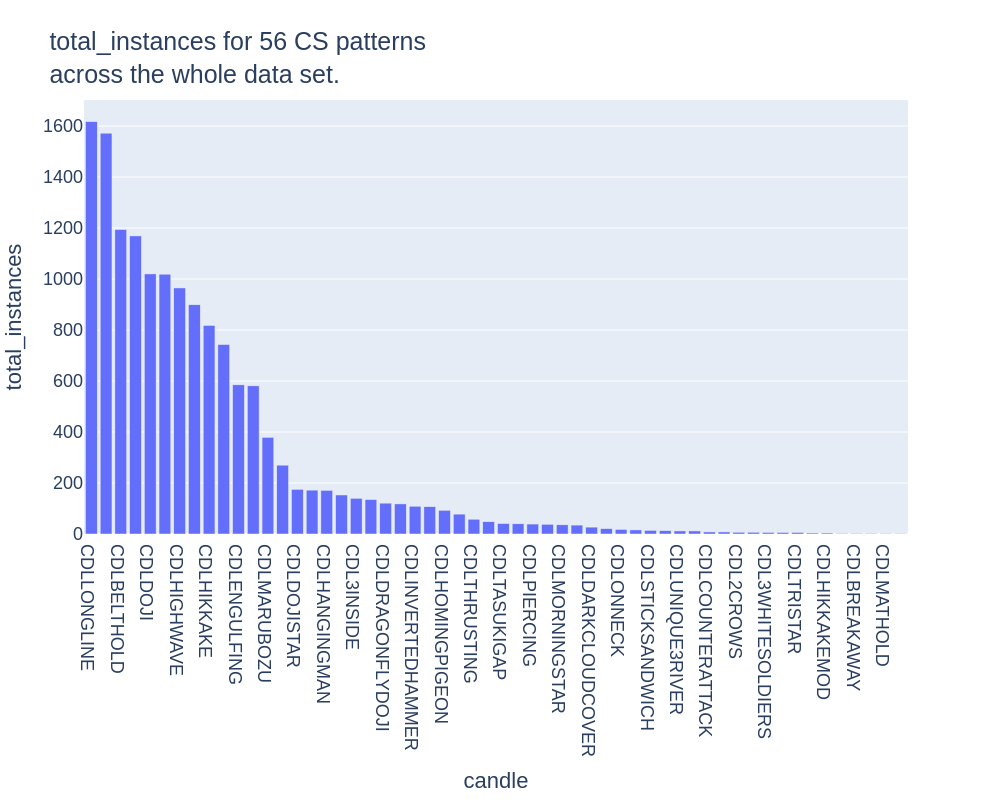

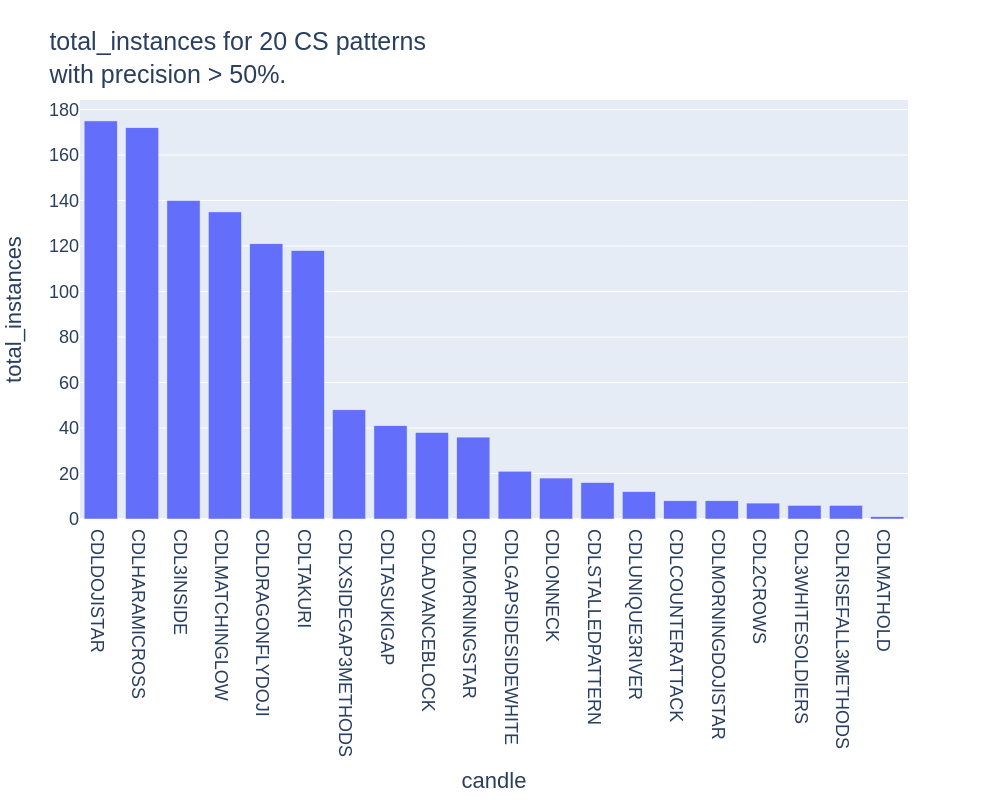

In [20]:
# plot all patterns, ranked by number of instances
plot_cs_performance(
    df=performance_metrics,
    criterion="total_instances",
    title_suffix="across the whole data set.",
)

# plot the patterns, ranked by number of instances, with a true-positive rate >50%.
plot_cs_performance(
    df=performance_metrics.query("precision > 0.5").sort_values(
        by="total_instances", ascending=False
    ),
    criterion="total_instances",
    title_suffix="with precision > 50%.",
)

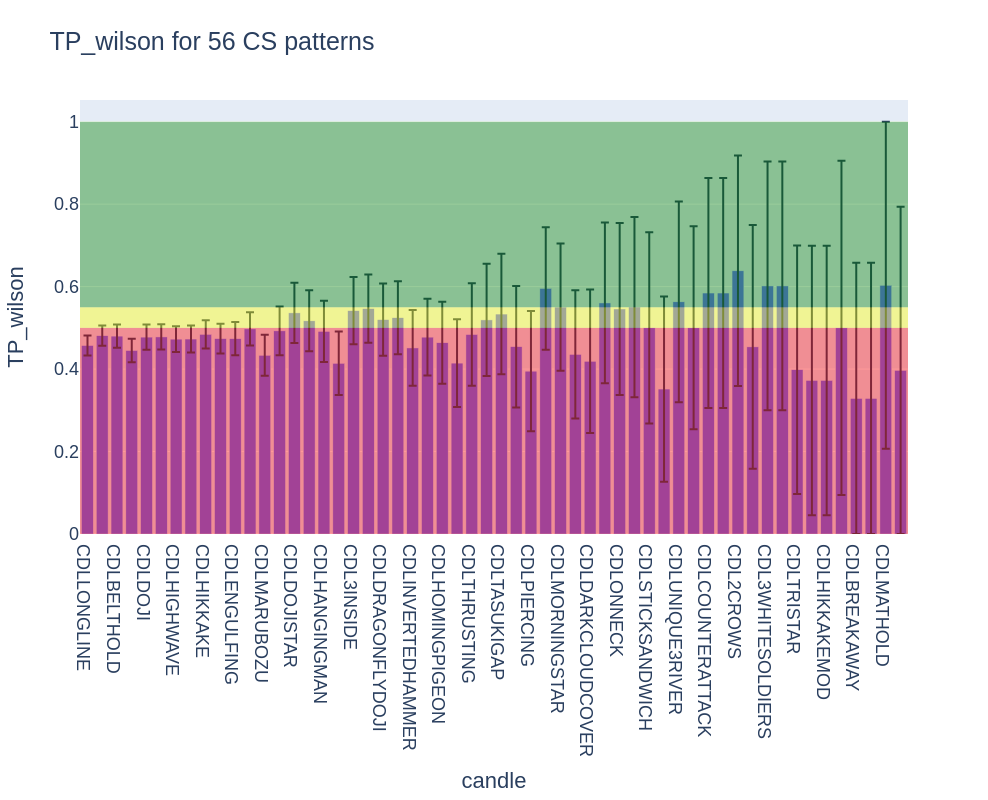

In [21]:
plot_cs_performance(
    df=performance_metrics, criterion="TP_wilson", plot_performance=True
)

In [22]:
performance_metrics.query("ci_lower > 0.45 and TP_wilson > 0.5")

TP  FP  total_instances  precision    center    margin  \
candle                                                                   
CDLDOJISTAR     94  81              175   0.537143  0.536345  0.073082   
CDL3INSIDE      76  64              140   0.542857  0.541713  0.081417   
CDLMATCHINGLOW  74  61              135   0.548148  0.546816  0.082793   

                ci_upper  ci_lower  TP_wilson  
candle                                         
CDLDOJISTAR     0.609427  0.463263   0.536345  
CDL3INSIDE      0.623130  0.460295   0.541713  
CDLMATCHINGLOW  0.629609  0.464023   0.546816

Our investigation into candlestick patterns reveals a nuanced landscape. While certain patterns exhibit a true positive metric exceeding 50%, suggesting potential trading viability, the rigorous step of evaluating their lower confidence intervals introduces a cautionary note. Specifically, for the cases examined, all lower confidence intervals fall below the 50% threshold in the single stock scenario, tempering initial optimism.

Among the patterns analyzed, `Dojistar`, `3 Inside`, and `Matchingglow` emerge as the most promising based on their performance metrics. However, it's premature to draw definitive conclusions. Given the inherently noisy nature of financial data, further exploration is warranted. To this end, we propose two avenues for deepening our analysis:

- Aggregation of signals: Investigating the potential benefits of aggregating signals from multiple patterns or across a broader dataset may reveal underlying trends or strengthen predictive signals that were not apparent in isolated analysis.

- Application of machine learning lechniques: Leveraging machine learning can offer an avenue for pattern recognition and prediction, potentially uncovering non-linear patterns that are obscured to us and difficult to detect otherwise. 

# Developing and back-testing trading strategies: Buy and hold vs. naive candlestick signals vs. Machine Learning applied to candlestick patterns 

## Aggregating trading signals

In the following we aggregate the "predictive power" of all candlestick patterns detectable by `talib` to produce a trading signal that we can backtest.  

In [23]:
cs_signals_df[
    "cs_pattern"
].value_counts()  # how many individual predictions do we have?

cs_pattern
 100    9333
-100    5433
-200      89
 200      80
Name: count, dtype: int64

In [24]:
# We pivot our multi-indexed data frame and sum across all patterns applying the "principle of superposition"
trading_signal = (
    cs_signals_df[cs_signals_df["cs_pattern"] != 0][["cs_pattern"]]
    .pivot_table(index="date", columns="candle", values="cs_pattern", aggfunc="sum")
    .sum(axis=1)
    .loc[lambda x: x != 0]
)
trading_signal

date
1992-06-29    200.0
1992-06-30   -200.0
1992-07-01    100.0
1992-07-02   -200.0
1992-07-07   -100.0
              ...  
2022-12-20    100.0
2022-12-21    100.0
2022-12-27   -200.0
2022-12-28    100.0
2022-12-29    200.0
Length: 5692, dtype: float64

On 1992-06-29 we receive a bullish signal that we can act upon at the earliest upon market opeing on the next available trading day, which was 1992-06-30. After having some nostalgic moments of seemingly better times "back in the good old days", we note to account the delay between signal and earliest possible action, by offsetting the signal by one. Otherwise we unwantedly introduce look-ahead bias which is often associated with deceivingly high returns, that almost surely result in a deadly blow applying the "strategy" in practice. For convenience, we plot the signal as well. 

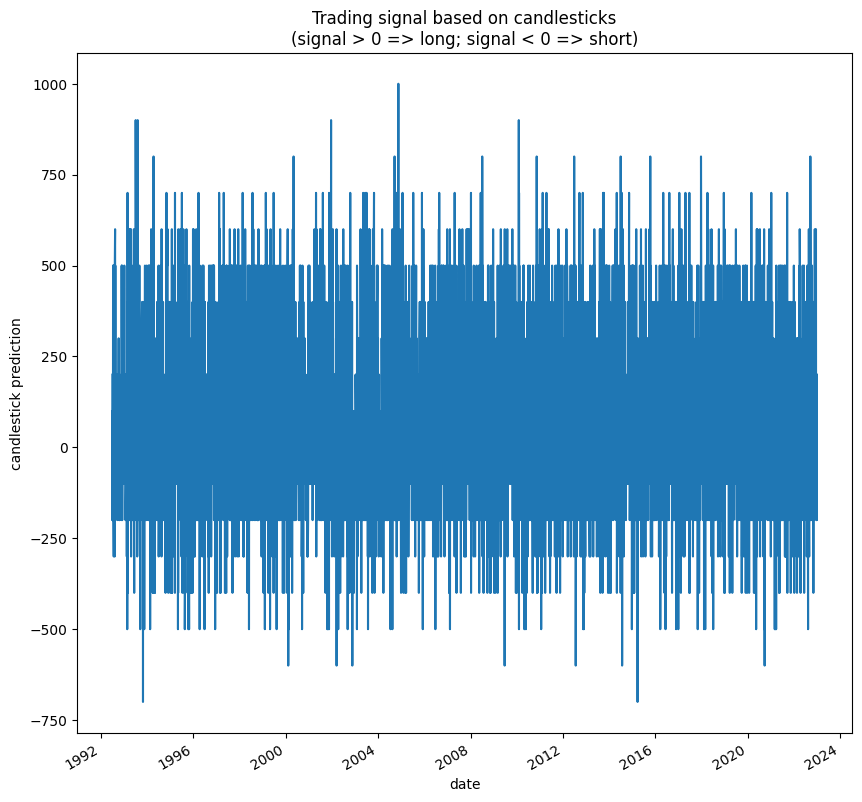

In [25]:
trading_signal.plot(
    figsize=(10, 10),
    title="Trading signal based on candlesticks\n(signal > 0 => long; signal < 0 => short)",
)
plt.ylabel("candlestick prediction")
plt.show()

## How does acting on the trading signals compare to a buy-and-hold strategy?

In [26]:
performance_trading_signals = (
    df[
        df["date"].isin([date + pd.DateOffset(days=1) for date in trading_signal.index])
    ][["date", "intraday_return"]]
    .assign(account_curve=lambda x: (1 + x["intraday_return"]).cumprod())
    .assign(cumsumret=lambda x: x["intraday_return"].cumsum())
    .assign(time_between_signals=lambda x: x["date"].diff().dt.days)
)

performance_trading_signals.head(5)

date  intraday_return  account_curve  cumsumret  time_between_signals
11 1992-06-30        -0.037801       0.962199  -0.037801                   NaN
12 1992-07-01         0.026690       0.987881  -0.011110                   1.0
13 1992-07-02        -0.039519       0.948841  -0.050629                   1.0
16 1992-07-08         0.009191       0.957562  -0.041438                   6.0
18 1992-07-10         0.001805       0.959290  -0.039633                   2.0

In [27]:
# The reference strategy will be a buy-and hold approach.
# For consistency, we employ intraday returns for the reference strategy as well which is chosen not entirely selflessly
# and avoid us to adjust the prices for stock splits and dividends, as this is an entire topic on its own.
df_reference_strategy = df[["date", "intraday_return"]].copy()
df_reference_strategy["account_curve"] = (
    1 + df_reference_strategy["intraday_return"]
).cumprod()
df_reference_strategy["cumsumret"] = df_reference_strategy["intraday_return"].cumsum()

Finally, we are in a position to compare the the buy-and-hold reference trading strategy against the one obtained from the candlestick patterns. The function `compute_trading_strategy_performance` thereby assesses the key performance characteristics of the strategies, namely `annualised return`, `annualised volatility`, and `annualised Sharpe Ratio`.

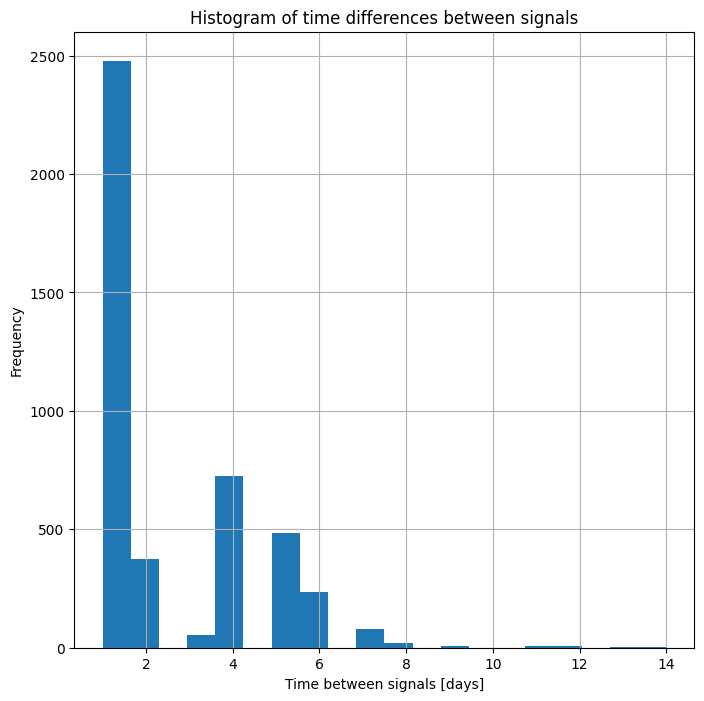

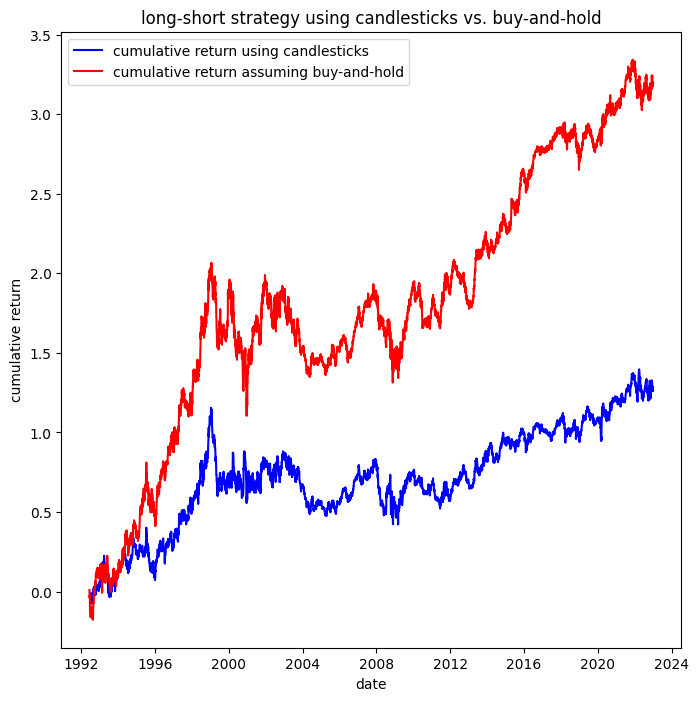

Performance of the naive aggregated candlestick strategy
Annualised strategy return [%]: 0.0745
Annualised strategy standard deviation of returns [%]: 0.2586
Sharpe ratio of strategy: 0.2879

Performance of the reference strategy
Annualised strategy return [%]: 0.1082
Annualised strategy standard deviation of returns [%]: 0.2625
Sharpe ratio of strategy: 0.4120


In [28]:
# Calculate the cumulative sum of intraday returns to plot the account curve

performance_trading_signals.hist(column="time_between_signals", bins=20, figsize=(8, 8))
plt.xlabel("Time between signals [days]")
plt.ylabel("Frequency")
plt.title("Histogram of time differences between signals")
plt.show()

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(
    performance_trading_signals["date"],
    performance_trading_signals["cumsumret"],
    label="cumulative return using candlesticks",
    color="b",
)
ax.plot(
    df_reference_strategy["date"],
    df_reference_strategy["cumsumret"],
    label="cumulative return assuming buy-and-hold",
    color="r",
)
ax.set_xlabel("date")
ax.set_ylabel("cumulative return")
ax.legend(loc="upper left")
ax.set_title("long-short strategy using candlesticks vs. buy-and-hold")
plt.show()

# Compute trading strategy statistics
print("Performance of the naive aggregated candlestick strategy")
compute_trading_strategy_performance(df=performance_trading_signals, verbose=True)
print()
print("Performance of the reference strategy")
compute_trading_strategy_performance(df=df_reference_strategy, verbose=True);

Upon aggregating signals from all candlestick patterns, we observe a signal nearly every trading day, alongside a marginally lower annualized volatility compared to the benchmark buy-and-hold strategy. However, these advantages are overshadowed by the superior performance of the buy-and-hold strategy, which not only delivers higher returns but also boasts a 38% higher Sharpe Ratio. Furthermore, when considering transaction costs—which are significantly lower for the buy-and-hold strategy due to its singular trading requirement—the choice between these two strategies becomes straightforward. The buy-and-hold strategy's efficiency and cost-effectiveness make it the preferred option over the active trading approach suggested by candlestick patterns.  
There is only one caveat regarding the buy-and-hold approach: We no not know a priori whether a stock goes up-or down. Let us now proceed to our final strategy in this notebook, namely applying Machine learnign to candlestick patterns.

# Does Machine learning help to to reduce the noise of the signals?

The following code pivots the dataframe such that we obtain the date as an index and the candlestick signals as columns. Joinging two or more data frames is a very important and frequently occuring task in data science in general and computing in particular, and again a topic on its own. The author encourages you to study merge, joins and concatonations of dataframes in your own time, as we need to focus here at the task at hand, however, I cannot stress their importance enough. Again, method chaining shows the step-by-step approach which keeps this cruicial step transparent, yet concise. 

In [29]:
df_signal_and_return = (
    cs_signals_df.reset_index()
    .pivot_table(index="date", columns="candle", values="cs_pattern", aggfunc="first")
    .fillna(0)
    .join(df.set_index("date")[["sign_next_day_return"]], how="left")
)

df_signal_and_return.head()

CDL2CROWS  CDL3BLACKCROWS  CDL3INSIDE  CDL3LINESTRIKE  \
date                                                                
1992-06-29        0.0             0.0         0.0             0.0   
1992-06-30        0.0             0.0         0.0             0.0   
1992-07-01        0.0             0.0         0.0             0.0   
1992-07-02        0.0             0.0         0.0             0.0   
1992-07-06        0.0             0.0         0.0             0.0   

            CDL3OUTSIDE  CDL3WHITESOLDIERS  CDLADVANCEBLOCK  CDLBELTHOLD  \
date                                                                       
1992-06-29          0.0                0.0              0.0        100.0   
1992-06-30          0.0                0.0              0.0       -100.0   
1992-07-01          0.0                0.0              0.0          0.0   
1992-07-02          0.0                0.0              0.0       -100.0   
1992-07-06       -100.0                0.0              0.0          0.0   

            CDLBREAKAWAY  CDLCLOSINGMARUBOZU  CDLCOUNTERATTACK  \
date                                                             
1992-06-29           0.0                 0.0               0.0   
1992-06-30           0.0                 0.0               0.0   
1992-07-01           0.0                 0.0               0.0   
1992-07-02           0.0                 0.0               0.0   
1992-07-06           0.0                 0.0               0.0   

            CDLDARKCLOUDCOVER  CDLDOJI  CDLDOJISTAR  CDLDRAGONFLYDOJI  \
date                                                                    
1992-06-29                0.0      0.0          0.0               0.0   
1992-06-30                0.0      0.0          0.0               0.0   
1992-07-01                0.0      0.0          0.0               0.0   
1992-07-02                0.0      0.0          0.0               0.0   
1992-07-06                0.0      0.0          0.0               0.0   

            CDLENGULFING  CDLEVENINGDOJISTAR  CDLEVENINGSTAR  \
date                                                           
1992-06-29           0.0                 0.0             0.0   
1992-06-30           0.0                 0.0             0.0   
1992-07-01           0.0                 0.0             0.0   
1992-07-02        -100.0                 0.0             0.0   
1992-07-06           0.0                 0.0             0.0   

            CDLGAPSIDESIDEWHITE  CDLGRAVESTONEDOJI  CDLHAMMER  CDLHANGINGMAN  \
date                                                                           
1992-06-29                  0.0                0.0        0.0            0.0   
1992-06-30                  0.0                0.0        0.0            0.0   
1992-07-01                  0.0                0.0        0.0            0.0   
1992-07-02                  0.0                0.0        0.0            0.0   
1992-07-06                  0.0                0.0      100.0            0.0   

            CDLHARAMI  CDLHARAMICROSS  CDLHIGHWAVE  CDLHIKKAKE  CDLHIKKAKEMOD  \
date                                                                            
1992-06-29        0.0             0.0          0.0         0.0            0.0   
1992-06-30        0.0             0.0          0.0         0.0            0.0   
1992-07-01        0.0             0.0          0.0         0.0            0.0   
1992-07-02        0.0             0.0          0.0         0.0            0.0   
1992-07-06        0.0             0.0          0.0         0.0            0.0   

            CDLHOMINGPIGEON  CDLIDENTICAL3CROWS  CDLINNECK  CDLINVERTEDHAMMER  \
date                                                                            
1992-06-29              0.0                 0.0        0.0                0.0   
1992-06-30              0.0                 0.0        0.0                0.0   
1992-07-01              0.0                 0.0        0.0                0.0   
1992-07-02              0.0          

In the next cell, it is demonstrated explicitely that the column named `sign_next_day_return` is a categorical variable. Either the return can be positive or negative. Let us neglect the few cases where they are zero. We will filter these cases as to limit ourselves witha binary classification problem. Technically, we could, in logistic regression, accommodate for the occurance of three cathegorical variables, namely positive returns, negative returns and zero returns. However, zero returns rarely occur, and machine learning is data hungy. Hence, we filter them out. Also, the next cell shows that days of zero returns are a clear minority anyway. Hence, we feel comfortable our slight simplification is indeed empirically justified. 

In [30]:
df_signal_and_return["sign_next_day_return"].value_counts(normalize=True)

sign_next_day_return
1     0.496058
-1    0.486695
0     0.017247
Name: proportion, dtype: Float64

In [31]:
N_CORES = multiprocessing.cpu_count()
TEST_SIZE = 0.1

df_filtered = df_signal_and_return[df_signal_and_return["sign_next_day_return"] != 0]

X = df_filtered.iloc[:, :-1]
y = df_filtered.iloc[:, -1].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, shuffle=False
)

# let us quickly confirm whether the percentage of our train-test split is correct
print(X_train.__len__() / X.__len__())
print(X_test.__len__() / X.__len__())

0.8998830018385425
0.10011699816145746


Note: You could have also slided the data set into training and test splits yourself, for example like so:

```
split_index = int(0.8 * len(df_filtered))  # 80% for training, 20% for testing
df_train = df_filtered.iloc[:split_index]
df_test = df_filtered.iloc[split_index:]
```

In `Python` and `Pandas`, slicing follows a consistent rule: the start index is included, and the stop index 
is excluded. This is known as half-open interval: `[start, stop)`. Hence, slicing is end-exclusive and `df_train` and `df_test` are non-overlapping. Hence, slicing achieves the same result we achieved by using `sklearn's train_test_split`. 

Let us now fit the logistic regressor to the training data.

In [32]:
%%time

model = LogisticRegression(max_iter=5000, tol=0.01, n_jobs=N_CORES)
model.fit(X_train, y_train)

# Prediction on training set
pred_train = model.predict(X_train)
assert len(pred_train) == len(y_train)

# Prediction on test set
pred_test = model.predict(X_test)
assert len(pred_test) == len(y_test)

print(
    "Compute hit-rate of strategy obtained by the logistic regressor on the TRAINING set"
)
print((pred_train == y_train).sum() / len(y_train), end="\n\n")

print("Compute hit-rate of strategy obtained by the logistic regressor on the TEST set")
print((pred_test == y_test).sum() / len(y_test), end="\n\n")

Compute hit-rate of strategy obtained by the logistic regressor on the TRAINING set
0.5338038632986627

Compute hit-rate of strategy obtained by the logistic regressor on the TEST set
0.5208681135225376

CPU times: user 56.5 ms, sys: 132 ms, total: 188 ms
Wall time: 694 ms


In [33]:
# quick remark: we could have achieved the same result more tersly, opon invoking:
np.mean(pred_test == y_test)

0.5208681135225376

Why can we use `np.mean(pred == y_test)` to compute the hit-rate efficiently?

This is because of how boolean values are treated in numerical operations in Python. When you compare two arrays (or lists) element-wise for equality (pred == y_test), you get an array of boolean values (True or False). In this boolean array, True represents a hit (where the corresponding elements in pred and y_test are equal), and False represents a miss.

In Python, boolean values are a subtype of integers. True is treated as 1, and False is treated as 0. Therefore, when you calculate the mean of an array of boolean values, you are effectively calculating the proportion of True values in the array. This is exactly the hit rate - the proportion of times pred and y_test are equal. The sum of this boolean array gives you the number of hits (since True is 1 and False is 0, the sum is the count of True values).

Dividing this sum by the length of the array gives you the average value, which is the proportion of hits.
So, np.mean(pred == y_test) is a neat way to calculate the hit rate directly from the arrays without explicitly counting the hits and dividing by the total number of elements.

In [34]:
y_train.value_counts(
    normalize=True
)  # the training set caontains an approximately equal proportion of postitive and negative returns

sign_next_day_return
 1    0.502043
-1    0.497957
Name: proportion, dtype: float64

In [35]:
y_test.value_counts(
    normalize=True
)  # the test set contains more positive than negative returns

sign_next_day_return
 1    0.529215
-1    0.470785
Name: proportion, dtype: float64

In [36]:
performance_ml_strategy = (
    df[df["date"].isin(y_test.index)][
        ["date", "intraday_return", "sign_next_day_return"]
    ]
    .dropna()
    .reset_index(drop=True)
    .assign(pred=pred_test)  # directly assigning pred without reindexing
    .assign(
        daily_return_strategy=lambda x: np.where(
            np.sign(x["sign_next_day_return"]) == np.sign(x["pred"]),
            abs(x["intraday_return"]),
            -abs(x["intraday_return"]),
        )
    )
    .assign(account_curve=lambda x: x["daily_return_strategy"].cumsum())
    .assign(contrarian_account_curve=lambda x: -1 * x["daily_return_strategy"])
)
performance_ml_strategy

date  intraday_return  sign_next_day_return  pred  \
0   2020-01-30        -0.007297                    -1    -1   
1   2020-01-31        -0.011498                     1     1   
2   2020-02-03         0.023177                     1    -1   
3   2020-02-05        -0.022442                     1    -1   
4   2020-02-06         0.014699                     1    -1   
..         ...              ...                   ...   ...   
594 2022-12-20         0.010025                     1    -1   
595 2022-12-21         0.011337                    -1    -1   
596 2022-12-27        -0.007289                    -1     1   
597 2022-12-28        -0.009962                     1    -1   
598 2022-12-29         0.022746                     1     1   

     daily_return_strategy  account_curve  contrarian_account_curve  
0                 0.007297       0.007297                 -0.007297  
1                 0.011498       0.018794                 -0.011498  
2                -0.023177      -0.004382                  0.023177  
3                -0.022442      -0.026824                  0.022442  
4                -0.014699      -0.041523                  0.014699  
..                     ...            ...                       ...  
594              -0.010025       0.601202                  0.010025  
595               0.011337       0.612538                 -0.011337  
596              -0.007289       0.605249                  0.007289  
597              -0.009962       0.595286                  0.009962  
598               0.022746       0.618032                 -0.022746  

[599 rows x 7 columns]

Sum of percentages for hits histogram: 1.0
Sum of percentages for misses histogram: 1.0


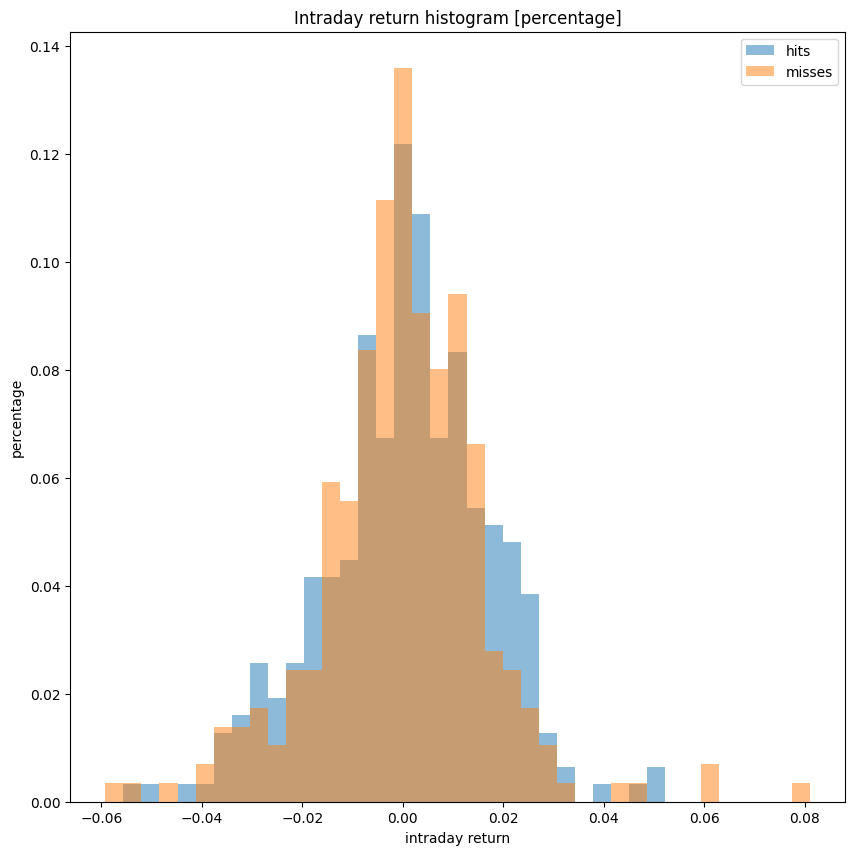

In [37]:
plt.figure(figsize=(10, 10))

# Define common bins
min_value = min(
    performance_ml_strategy["intraday_return"].min(),
    performance_ml_strategy["intraday_return"].min(),
)
max_value = max(
    performance_ml_strategy["intraday_return"].max(),
    performance_ml_strategy["intraday_return"].max(),
)
bins = np.linspace(min_value, max_value, 40)

# Calculate histogram for 'hits'
hits_data = performance_ml_strategy[
    performance_ml_strategy["sign_next_day_return"] == performance_ml_strategy["pred"]
]["intraday_return"]
counts_hits, _ = np.histogram(hits_data, bins=bins)
percent_hits = counts_hits / counts_hits.sum()

# Calculate histogram for 'misses'
misses_data = performance_ml_strategy[
    performance_ml_strategy["sign_next_day_return"] != performance_ml_strategy["pred"]
]["intraday_return"]
counts_misses, _ = np.histogram(misses_data, bins=bins)
percent_misses = counts_misses / counts_misses.sum()

# Verify that the sum of the percentages is equal to 1
print("Sum of percentages for hits histogram:", np.sum(percent_hits))
print("Sum of percentages for misses histogram:", np.sum(percent_misses))

# Plot the histograms
plt.hist(bins[:-1], bins, weights=percent_hits, alpha=0.5, label="hits")
plt.hist(bins[:-1], bins, weights=percent_misses, alpha=0.5, label="misses")

plt.legend()
plt.title("Intraday return histogram [percentage]")
plt.xlabel("intraday return")
plt.ylabel("percentage")
plt.show()

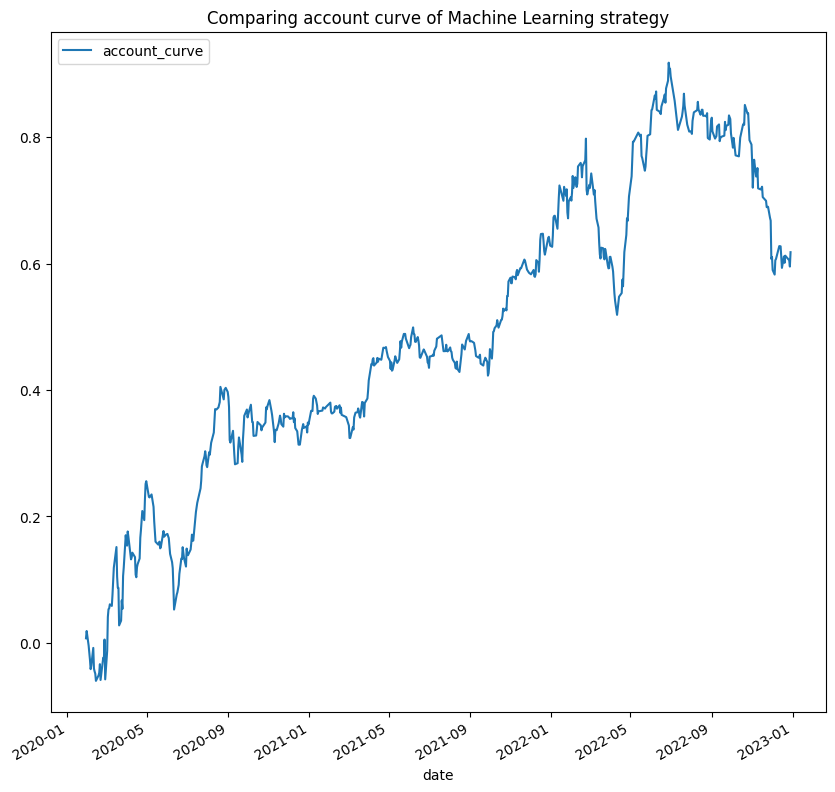

In [38]:
performance_ml_strategy.plot(
    x="date",
    y="account_curve",
    title="Comparing account curve of Machine Learning strategy",
    figsize=(10, 10),
)
plt.show()

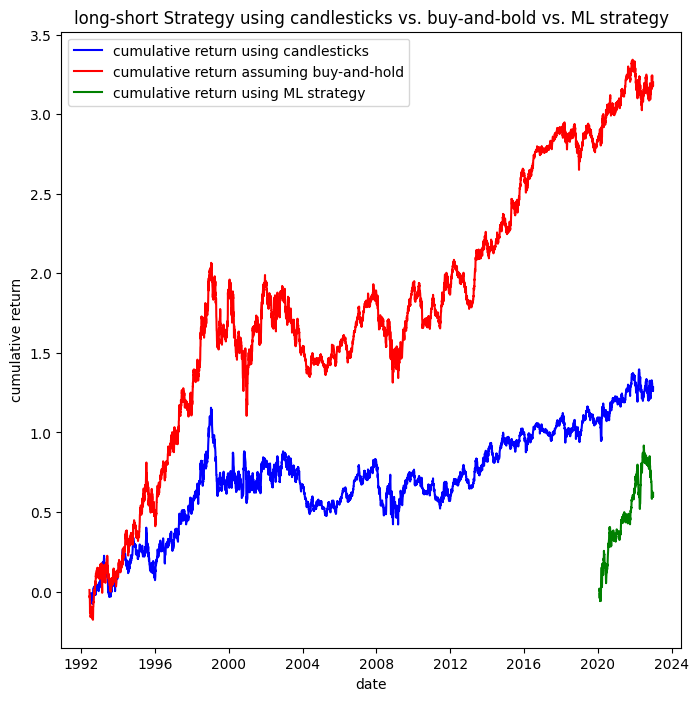

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plotting the first curve
ax.plot(
    performance_trading_signals["date"],
    performance_trading_signals["cumsumret"],
    label="cumulative return using candlesticks",
    color="b",
)

# Plotting the second curve
ax.plot(
    df_reference_strategy["date"],
    df_reference_strategy["cumsumret"],
    label="cumulative return assuming buy-and-hold",
    color="r",
)

# Adding the third curve from 'tmp'
ax.plot(
    performance_ml_strategy["date"],
    performance_ml_strategy["account_curve"],
    label="cumulative return using ML strategy",
    color="g",
)  # Assuming color green

ax.set_xlabel("date")
ax.set_ylabel("cumulative return")
ax.legend(loc="upper left")
ax.set_title("long-short Strategy using candlesticks vs. buy-and-bold vs. ML strategy")

plt.show()

In [40]:
# investigate the account curve at the end of the test period
performance_ml_strategy.tail(2)

date  intraday_return  sign_next_day_return  pred  \
597 2022-12-28        -0.009962                     1    -1   
598 2022-12-29         0.022746                     1     1   

     daily_return_strategy  account_curve  contrarian_account_curve  
597              -0.009962       0.595286                  0.009962  
598               0.022746       0.618032                 -0.022746

In [41]:
# annual geometric return during test period (the past three years)
(1 + performance_ml_strategy["account_curve"].iloc[-1]) ** (1 / 3) - 1

0.17398453769450772

In [42]:
compute_trading_strategy_performance(df=performance_ml_strategy, verbose=True);

Annualised strategy return [%]: 0.0997
Annualised strategy standard deviation of returns [%]: 0.2673
Sharpe ratio of strategy: 0.3730


In [43]:
(1 + 0.2173742597803736) ** 3 - 1  # 3 years of history for the test set

0.8041487605809532

# Summary

## Recursive feature elimination

`sklearn.feature_selection.RFECV` is a feature selection method from scikit-learn that stands for `Recursive Feature Elimination with Cross-Validation`. It is used to select the most significant features by recursively considering smaller and smaller sets of features.

- Recursive Feature Elimination (RFE): It fits a model and removes the weakest feature(s) (i.e., the feature(s) with the least importance according to the model), then fits a new model on the reduced dataset. This process is repeated until all features have been ranked by their importance.


- Cross-Validation (CV): The RFE procedure is embedded within a cross-validation loop to determine the optimal number of features. For each iteration, a different subset of the data is used for training and validation, and the performance of the model is assessed. This helps to ensure that the selection of features is robust and performs well on unseen data.


`selector.ranking_`: This array shows the ranking of features. A rank of 1 indicates that the feature was selected as important. Higher ranks indicate the order in which features were removed, where a rank of 2 means the feature was the second least important, a rank of 3 means the feature was the third least important, and so on.

Looking at `selector.ranking_` array, it seems that most features were selected (rank 1). Some features have higher rank values, like 4 and 3 indicating their relative importance was considered lower by the `RFECV` process. These features were removed in the corresponding iterations of the feature elimination process.

The feature with a rank of 4 was removed first, the one with 3 was removed second, and this pattern continues until all features with a rank greater than 1 are removed. The features with a rank of 1 are considered important and are selected by the `RFECV`. These are the features you might consider keeping in your model for the best balance between model complexity and performance as determined by cross-validation.

In [44]:
%%time
# takes a about 80 seconds to run for one stock, but surely is dependent on the number of CPU cores on your machine.

N_CORES = multiprocessing.cpu_count()
model = LogisticRegressionCV(
    cv=5, multi_class="ovr", max_iter=1000, n_jobs=N_CORES
)  # If we choose multi_class=‘ovr’, then a binary problem is fit for each label.
model.fit(X_train, y_train)

selector = RFECV(model, cv=5, n_jobs=N_CORES)
selector.fit(X_train, y_train)
print(selector.ranking_)
selected_features = selector.get_support()

[ 1  1  1  1 15  1  1 13  1  1  1  1  1  3  1 21  1  5  1 17  1  7 22  1
  8 10  2  1  1  1  4  1  1  9 12  1  1  1  6  1  1 16  1  1  1 14 11  1
  1  1 19 20  1  1  1 18]
CPU times: user 25 s, sys: 25.1 s, total: 50.1 s
Wall time: 1min 36s


In [45]:
selector.ranking_.__len__()  # this corresponds to the number of candlesticks we investigate

56

In [46]:
pred = model.predict(X_test)
assert len(pred) == len(y_test)
print("Compute hit-rate of strategy obtained from the logistic regressor")
print((pred == y_test).sum() / len(y_test))
model.score(X_test, y_test)  # gives same result

Compute hit-rate of strategy obtained from the logistic regressor
0.5242070116861436


0.5242070116861436

In [47]:
# Apply this mask to X_train and X_test to keep only important features
X_train_selected = X_train.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]

# Refit the model on the selected features
model_selected = LogisticRegressionCV(
    cv=5, multi_class="ovr", max_iter=1000, n_jobs=N_CORES
)
model_selected.fit(X_train_selected, y_train)

y_pred_selected = model_selected.predict(X_test_selected)
model_selected.score(X_test_selected, y_test)

0.5008347245409015

Unfortunately, recursive feature elimination did not imporove the Machine Learning strategy.

# Your task: Can you improve the strategy further?

In [48]:
# your improvements go here

# Literature 

[1] Young Ho Seo, Scientific Guide To Price Action and Pattern Trading Wisdom of Trend, Cycle, and Fractal Wave 


[2] Thomas N. Bulkowski, Encyclopedia of Chart Patterns, Wiley Trading, 2021.

If you are interested to back-test more trading strategies, you can look at:

[3] Finding Alphas: A Quantitative Approach to Building Trading Strategies Hardcover – 27 Sept. 2019 by Igor Tulchinsky (Editor)

[4] 151 Trading Strategies, Z. Kakushadze and J.A. Serur. 151 Trading Strategies. Cham, Switzerland: Palgrave Macmillan, an imprint of Springer Nature, 1st Edition (2018), XX, 480 pp; ISBN 978-3-030-02791-9, https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3247865

# Appendix

## A side note regarding software engineering terminology

In this notebook, we embarked on the term `high cohesion`. Another important concept is `coupling`, which refers to the degree of direct knowledge one component has of another. It is a measure of how closely connected different modules or components are within a system, indicating the level of dependency between them. Understanding coupling is important for designing maintainable, scalable, and resilient software systems. There are generally two types of coupling: high (or tight) coupling and low (or loose) coupling.

- High (tight) coupling:
High coupling occurs when components are heavily dependent on each other. This means that a change in one component often necessitates changes in another, leading to a domino effect of modifications across the system. High coupling can make the system more complex and harder to understand, maintain, and test for several reasons:

    - Change propagation: Changes in one module can lead to required changes in dependent modules.
    - Difficulty in isolation: It becomes challenging to isolate modules for testing or for use in different contexts.
    - Reduced reusability: Tightly coupled modules are often less reusable since they depend heavily on specific behavior in other parts of the system.

- Low (loose) coupling:
Loose coupling, on the other hand, is characterized by a minimal level of dependency among components. In a loosely coupled system, changes in one component have minimal or no impact on others. This approach offers several advantages:

    - Ease of modification: Modules can be changed, replaced, or updated with minimal impact on the rest of the system.
    - Enhanced testability: Components can be tested in isolation, simplifying the testing process.
    - Increased reusability: Modules designed with few dependencies can be easily reused in different parts of the system or in different projects.

- Achieving loose coupling:
Loose coupling can be achieved through various design principles and patterns, including:
    - Interface-based design: Defining clear interfaces between components so that they communicate using abstract contracts rather than concrete implementations.
    - Dependency injection: Passing dependencies into an object rather than having it create them internally.
    - Service-Oriented Architecture (SOA) or Microservices: Designing systems as collections of loosely coupled services.
    - Publish-subscribe models: Components communicate through events or messages rather than direct calls, which decouples the sender from the receiver.